In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
from torchvision.models import resnet18, ResNet18_Weights
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

import copy
from time import perf_counter

In [2]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

train = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train
)
test = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test
)
train_loader = DataLoader(train, batch_size=128, shuffle=True)
test_loader = DataLoader(test, batch_size=256, shuffle=False)


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
weights = ResNet18_Weights.DEFAULT


In [4]:
base_model = resnet18(weights=weights).to(device)
base_model.fc = nn.Linear(512, 10, bias=True).to(device)

In [5]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total

@torch.no_grad()
def evaluate(model, dataloader, device):
    model.eval()
    correct, total = 0, 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    return correct / total


In [6]:
optimizer = torch.optim.Adam(base_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

for epoch in range(20):
    train_loss, train_acc = train_one_epoch(base_model, train_loader, optimizer, criterion, device)

    test_acc = evaluate(base_model, test_loader, device)

    print(f"Epoch {epoch}: "
          f"loss={train_loss:.4f}, "
          f"train_acc={train_acc:.4f}, "
          f"test_acc={test_acc:.4f}")

Epoch 0: loss=1.1993, train_acc=0.5779, test_acc=0.7175
Epoch 1: loss=0.7794, train_acc=0.7296, test_acc=0.7672
Epoch 2: loss=0.6617, train_acc=0.7697, test_acc=0.7887
Epoch 3: loss=0.5894, train_acc=0.7951, test_acc=0.8072
Epoch 4: loss=0.5318, train_acc=0.8125, test_acc=0.8125
Epoch 5: loss=0.4889, train_acc=0.8272, test_acc=0.8124
Epoch 6: loss=0.4513, train_acc=0.8415, test_acc=0.8233
Epoch 7: loss=0.4260, train_acc=0.8489, test_acc=0.8271
Epoch 8: loss=0.3919, train_acc=0.8605, test_acc=0.8305
Epoch 9: loss=0.3696, train_acc=0.8678, test_acc=0.8326
Epoch 10: loss=0.3485, train_acc=0.8768, test_acc=0.8352
Epoch 11: loss=0.3226, train_acc=0.8851, test_acc=0.8374
Epoch 12: loss=0.3114, train_acc=0.8901, test_acc=0.8410
Epoch 13: loss=0.2904, train_acc=0.8981, test_acc=0.8403
Epoch 14: loss=0.2784, train_acc=0.9008, test_acc=0.8478
Epoch 15: loss=0.2626, train_acc=0.9074, test_acc=0.8391
Epoch 16: loss=0.2464, train_acc=0.9123, test_acc=0.8431
Epoch 17: loss=0.2299, train_acc=0.9181, 

In [7]:
state_dict = base_model.state_dict()
for name, param in state_dict.items():
    print(name, param.shape)

conv1.weight torch.Size([64, 3, 7, 7])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
bn1.running_mean torch.Size([64])
bn1.running_var torch.Size([64])
bn1.num_batches_tracked torch.Size([])
layer1.0.conv1.weight torch.Size([64, 64, 3, 3])
layer1.0.bn1.weight torch.Size([64])
layer1.0.bn1.bias torch.Size([64])
layer1.0.bn1.running_mean torch.Size([64])
layer1.0.bn1.running_var torch.Size([64])
layer1.0.bn1.num_batches_tracked torch.Size([])
layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight torch.Size([64])
layer1.0.bn2.bias torch.Size([64])
layer1.0.bn2.running_mean torch.Size([64])
layer1.0.bn2.running_var torch.Size([64])
layer1.0.bn2.num_batches_tracked torch.Size([])
layer1.1.conv1.weight torch.Size([64, 64, 3, 3])
layer1.1.bn1.weight torch.Size([64])
layer1.1.bn1.bias torch.Size([64])
layer1.1.bn1.running_mean torch.Size([64])
layer1.1.bn1.running_var torch.Size([64])
layer1.1.bn1.num_batches_tracked torch.Size([])
layer1.1.conv2.weight torch.Size([64, 6

In [8]:
base_model.layer2[0].conv1.weight

Parameter containing:
tensor([[[[-6.4100e-02, -9.5543e-02, -1.2483e-01],
          [ 7.0312e-02, -1.2758e-02, -9.6394e-02],
          [ 1.1619e-01,  1.0514e-01,  2.0280e-02]],

         [[-1.6901e-02, -1.9388e-02, -9.7112e-03],
          [ 1.3320e-02,  5.0953e-03,  1.0497e-02],
          [ 1.0031e-02, -9.2471e-04, -3.4370e-03]],

         [[ 2.2433e-02,  9.2253e-03,  2.4967e-03],
          [-5.1585e-04, -1.8303e-02, -3.4304e-02],
          [ 2.0182e-02, -1.6654e-02, -3.1448e-02]],

         ...,

         [[ 3.3229e-02,  3.7536e-02,  3.3325e-02],
          [ 1.0360e-02,  1.7894e-02,  2.5875e-03],
          [-1.5749e-02, -8.7019e-03, -2.4848e-02]],

         [[-1.9821e-02, -2.7259e-02, -4.3588e-02],
          [ 5.5883e-03,  2.1964e-02, -3.6051e-02],
          [ 1.6483e-02,  6.0118e-02,  3.3947e-02]],

         [[ 1.8547e-02, -3.8727e-02, -5.3891e-03],
          [ 4.5471e-02,  5.7249e-03,  3.6235e-03],
          [ 3.6596e-02,  3.9119e-02,  4.0062e-02]]],


        [[[-5.1578e-02, -4.2628

In [9]:
base_model.fc.weight

Parameter containing:
tensor([[ 0.0261, -0.0188,  0.0091,  ...,  0.0009, -0.0492, -0.0414],
        [-0.0527, -0.0513, -0.0002,  ..., -0.0007,  0.0253,  0.0215],
        [ 0.0420, -0.0055,  0.0109,  ...,  0.0388,  0.0327, -0.0185],
        ...,
        [-0.0112, -0.0427, -0.0123,  ...,  0.0275, -0.0285, -0.0108],
        [ 0.0262,  0.0006, -0.0510,  ..., -0.0565,  0.0068,  0.0328],
        [ 0.0373, -0.0108,  0.0107,  ..., -0.0377,  0.0064,  0.0458]],
       device='cuda:0', requires_grad=True)

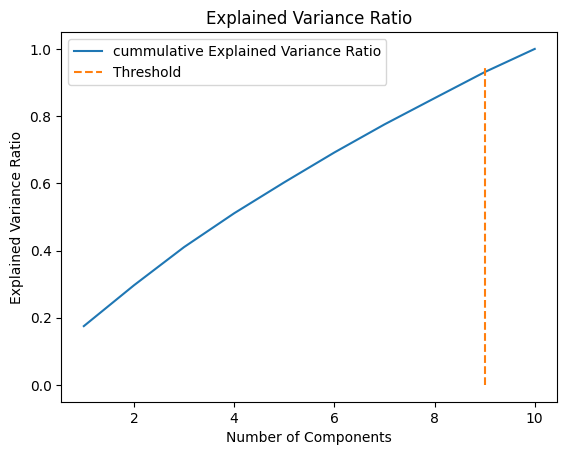

In [10]:
last_layer_w = base_model.fc.weight.detach().cpu()
last_layer_b = base_model.fc.bias.detach().cpu()

U, S, Vt = torch.linalg.svd(last_layer_w, full_matrices=False)

variance = S**2
variance_ratio = variance / variance.sum()
explained_var = torch.cumsum(variance_ratio, dim=0)
ind = torch.searchsorted(explained_var, 0.95) + 1

plt.plot(range(1, len(explained_var)+1), explained_var, label='cummulative Explained Variance Ratio')
plt.plot([ind-1, ind-1], [0, 0.95], linestyle='dashed', label='Threshold')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.legend()
plt.title('Explained Variance Ratio')
plt.show()


In [11]:
U_k, S_k, Vt_k = U[:, :ind], S[:ind], Vt[:ind, :]

fc1 = nn.Linear(512, ind, bias=False)
fc2 = nn.Linear(ind, 1000, bias=True)

fc1.weight.data = Vt_k
fc2.weight.data = U_k @ torch.diag(S_k)
fc2.bias.data = last_layer_b

nn.Sequential(fc1, fc2)

Sequential(
  (0): Linear(in_features=512, out_features=10, bias=False)
  (1): Linear(in_features=10, out_features=1000, bias=True)
)

In [12]:
def linear_layer_compressor(layer, EVR_frac):
    w = layer.weight.detach().cpu()
    w2d = w.reshape(w.shape[0], -1)

    U, S, Vt = torch.linalg.svd(w2d, full_matrices=False)

    variance = S ** 2
    variance_ratio = variance / variance.sum()
    explained_var = torch.cumsum(variance_ratio, dim=0)
    dim = torch.searchsorted(explained_var, EVR_frac) + 1

    U_r = U[:, :dim]
    S_r = S[:dim]
    Vt_r = Vt[:dim, :]

    l1 = nn.Linear(w.shape[1], dim, bias=False)

    b = layer.bias

    if b == None:
        l2 = nn.Linear(dim, w.shape[0], bias=False)

    else:
        l2 = nn.Linear(dim, w.shape[0], bias=True)
        l2.bias.data = b

    l1.weight.data = Vt_r
    l2.weight.data = U_r @ torch.diag(S_r)

    return nn.Sequential(l1, l2)


def conv_layer_compressor(layer, EVR_frac):
    w = layer.weight.detach().cpu()
    w2d = w.reshape(w.shape[0], -1)

    U, S, Vt = torch.linalg.svd(w2d, full_matrices=False)

    variance = S ** 2
    variance_ratio = variance / variance.sum()
    explained_var = torch.cumsum(variance_ratio, dim=0)
    dim = torch.searchsorted(explained_var, EVR_frac) + 1

    U_r = U[:, :dim]
    S_r = S[:dim]
    Vt_r = Vt[:dim, :]

    c1 = nn.Conv2d(
        in_channels=w.shape[1],
        out_channels=dim,
        kernel_size=(w.shape[2], w.shape[3]),
        stride=layer.stride,
        padding=layer.padding,
        dilation=layer.dilation,
        groups=layer.groups,
        bias=False
    )

    b = layer.bias

    if b == None:
        c2 = nn.Conv2d(
            in_channels=dim,
            out_channels=w.shape[0],
            kernel_size=1,
            bias=False
        )

    else:
        c2 = nn.Conv2d(
            in_channels=dim,
            out_channels=w.shape[0],
            kernel_size=1,
            bias=True
        )

        c2.bias.data = b

    c1.weight.data = Vt_r.reshape(dim, w.shape[1], w.shape[2], w.shape[3])
    c2.weight.data = (U_r @ torch.diag(S_r)).reshape(w.shape[0], dim, 1, 1)

    return nn.Sequential(c1, c2)


In [17]:
models = dict()
models['org'] = copy.deepcopy(base_model).to(device)
models[0.80] = copy.deepcopy(base_model).to(device)
models[0.50] = copy.deepcopy(base_model).to(device)

In [19]:
def compressor(model, thresh, device):
    for name, module in model.named_children():
        if isinstance(module, nn.Sequential) or isinstance(module, torchvision.models.resnet.BasicBlock):
            compressor(module, thresh, device)
        elif isinstance(module, nn.Linear):
            compressd_module = linear_layer_compressor(module, thresh)
            setattr(model, name, compressd_module.to(device))

        elif isinstance(module, nn.Conv2d):
            compressd_module = conv_layer_compressor(module, thresh)
            setattr(model, name, compressd_module.to(device))

In [21]:
compressor(models[0.50], 0.50, device)
compressor(models[0.80], 0.80, device)

In [22]:
print(
    f'original accuarcy: {evaluate(models['org'], test_loader, device)}'
    f'\n80% accuarcy: {evaluate(models[0.80], test_loader, device)}'
    f'\n50% accuarcy: {evaluate(models[0.50], test_loader, device)}'
)


original accuarcy: 0.8483
80% accuarcy: 0.3046
50% accuarcy: 0.1011


In [23]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

In [24]:
print(
    f'original parameters: {count_parameters(models['org']):,}'
    f'\n80% parameters: {count_parameters(models[0.80]):,}'
    f'\n50% parameters: {count_parameters(models[0.50]):,}'
)

original parameters: 11,181,642
80% parameters: 6,026,340
50% parameters: 2,568,695


In [25]:
criterion = nn.CrossEntropyLoss()

for t in models.keys():
  if t == 'org':
    continue

  optimizer = torch.optim.Adam(models[t].parameters(), lr=1e-4)
  print(f"\nModel {t}")
  for epoch in range(10):
      train_loss, train_acc = train_one_epoch(
          models[t], train_loader, optimizer, criterion, device
      )
      test_acc = evaluate(models[t], test_loader, device)

      print(f"Epoch {epoch}: "
            f"loss={train_loss:.4f}, "
            f"train_acc={train_acc:.4f}, "
            f"test_acc={test_acc:.4f}")

Epoch 0: loss=0.5380, train_acc=0.8244, test_acc=0.8082
Epoch 1: loss=0.3568, train_acc=0.8743, test_acc=0.8143
Epoch 2: loss=0.3150, train_acc=0.8885, test_acc=0.8265
Epoch 3: loss=0.2822, train_acc=0.9006, test_acc=0.8190
Epoch 4: loss=0.2679, train_acc=0.9055, test_acc=0.8237
Epoch 5: loss=0.2408, train_acc=0.9155, test_acc=0.8258
Epoch 6: loss=0.2361, train_acc=0.9164, test_acc=0.8242
Epoch 7: loss=0.2226, train_acc=0.9208, test_acc=0.8249
Epoch 8: loss=0.2034, train_acc=0.9282, test_acc=0.8314
Epoch 9: loss=0.1937, train_acc=0.9317, test_acc=0.8303
Epoch 0: loss=1.4542, train_acc=0.5171, test_acc=0.6058
Epoch 1: loss=1.0844, train_acc=0.6122, test_acc=0.6496
Epoch 2: loss=0.9728, train_acc=0.6496, test_acc=0.6849
Epoch 3: loss=0.9034, train_acc=0.6869, test_acc=0.7201
Epoch 4: loss=0.8441, train_acc=0.7144, test_acc=0.7294
Epoch 5: loss=0.7948, train_acc=0.7287, test_acc=0.7401
Epoch 6: loss=0.7676, train_acc=0.7386, test_acc=0.7458
Epoch 7: loss=0.7354, train_acc=0.7493, test_acc

In [26]:
accs = dict()
for t in models.keys():
  accs[t] = evaluate(models[t], test_loader, device)

for t in accs.keys():
  print(f'{t} accuracy: {accs[t]:.4f}')

org accuracy: 0.8483
0.8 accuracy: 0.8303
0.5 accuracy: 0.7693


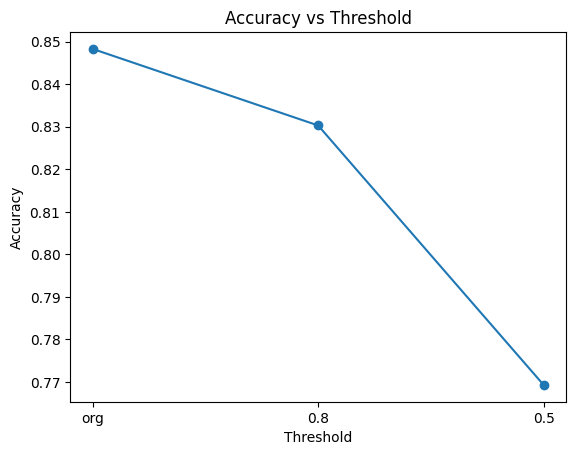

In [27]:
plt.plot(accs.keys(), accs.values(), marker='o')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Threshold')
plt.show()

In [30]:
device = 'cpu'
times = dict()

start = perf_counter()
evaluate(models['org'].cpu(), test_loader, device)
times['org'] = perf_counter() - start

start = perf_counter()
evaluate(models[0.80].cpu(), test_loader, device)
times[0.80] = perf_counter() - start

start = perf_counter()
evaluate(models[0.50].cpu(), test_loader, device)
times[0.50] = perf_counter() - start

for t in times.keys():
  print(f'{t} evaluation time on cpu: {times[t]:.4f}')

org evaluation time on cpu: 12.2721
0.8 evaluation time on cpu: 11.4036
0.5 evaluation time on cpu: 7.3972


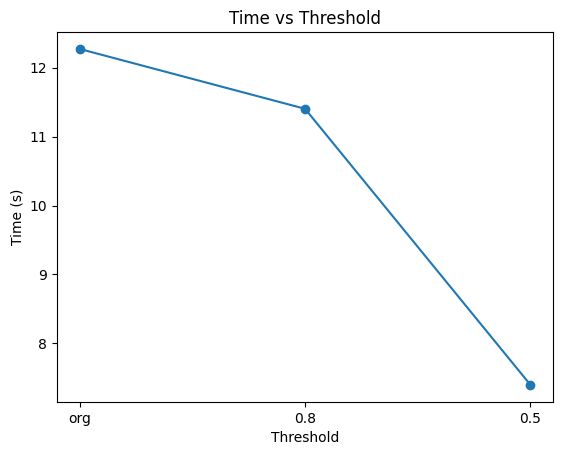

In [31]:
plt.plot(times.keys(), times.values(), marker='o')
plt.xlabel('Threshold')
plt.ylabel('Time (s)')
plt.title('Time vs Threshold')
plt.show()